In [1]:
import jax
from jax import numpy as jnp
import numpy as np
import mediapy
from tqdm import tqdm
import dataclasses

from scipy.interpolate import splprep, splev
from waymax import config as _config
from waymax import dataloader
from waymax import datatypes
from waymax import dynamics
from waymax import env as _env
from waymax import agents
from waymax import visualization
from waymax.agents import actor_core
from waymax.dynamics.tricycle_model import TricycleModel


In [2]:
def generate_racing_track(x, y, r, num_points=1000):
# Calculate tangent and normal vectors for each control point
    x_left = []
    y_left = []
    x_right = []
    y_right = []

    for i in range(len(x)):
        if i == 0:
            dx = x[i+1] - x[i]
            dy = y[i+1] - y[i]
        elif i == len(x) - 1:
            dx = x[i] - x[i-1]
            dy = y[i] - y[i-1]
        else:
            dx = x[i+1] - x[i-1]
            dy = y[i+1] - y[i-1]

        length = jnp.sqrt(dx**2 + dy**2)
        dx /= length
        dy /= length

        normal_x = -dy
        normal_y = dx

        width = r[i]  # Dynamic width based on r

        x_left.append(x[i] + normal_x * width / 2)
        y_left.append(y[i] + normal_y * width / 2)
        x_right.append(x[i] - normal_x * width / 2)
        y_right.append(y[i] - normal_y * width / 2)

    # Create new splines for left and right edges using the control points
    tck, _ = splprep([x, y], s=0, per=1)
    tck_left, _ = splprep([x_left, y_left], s=0, per=1)
    tck_right, _ = splprep([x_right, y_right], s=0, per=1)

    u_new = jnp.linspace(0, 1, num_points)
    x_center_smooth, y_center_smooth = splev(u_new, tck)
    x_left_smooth, y_left_smooth = splev(u_new, tck_left)
    x_right_smooth, y_right_smooth = splev(u_new, tck_right)

    return x_left_smooth, y_left_smooth, x_right_smooth, y_right_smooth, x_center_smooth, y_center_smooth

In [3]:
class TrackControlPoints:
    # Control points for the racing track, can be modified to create different tracks

    x = [30.3914, 34.5985, 37.9136, 41.6058, 44.124, 45.9188, 47.1959, 46.7351, 47.377, 47.6532, 46.6591, 
         46.5467, 47.6512, 50.0049, 52.5865, 53.9889, 54.3171, 54.2784, 53.4375, 52.333, 52.4365, 52.7472, 
         52.8369, 55.1218, 58.2352, 61.1966, 63.6817, 63.8858, 63.6888, 62.9846, 61.3693, 60.3086, 61.1369, 
         62.628, 63.8217, 63.6216, 63.6008, 60.7928, 57.7416, 55.1978, 52.4077, 50.7395, 48.7177, 46.7472, 
         44.5036, 42.2313, 40.4915, 39.5135, 38.3055, 36.587, 34.6551, 32.3964, 30.7208, 29.1654, 27.7528, 
         26.6793, 24.522, 22.221, 19.7474, 19.1721, 19.4022, 20.2766, 21.5824, 20.4607, 19.5942, 18.8348, 
         17.8684, 17.3219, 17.6429, 19.1694, 20.7179, 24.2734, 27.8213]
    y = [20.1282, 20.1528, 20.2138, 20.2842, 20.7843, 22.4755, 24.7191, 27.2454, 29.406, 31.7393, 34.3911, 
         36.9626, 39.0335, 39.6952, 39.4935, 37.7643, 35.5898, 33.2763, 30.4582, 27.3863, 25.0047, 22.5748, 
         20.3727, 19.9309, 19.6341, 19.5305, 20.4003, 23.1452, 25.8114, 27.7581, 29.2077, 32.5508, 35.243, 
         37.1483, 39.4283, 41.6718, 44.6677, 46.0382, 46.4869, 45.5216, 45.234, 45.2915, 46.1012, 46.1193, 
         45.9755, 45.6591, 44.8517, 43.0108, 41.8028, 40.0157, 38.8012, 39.2758, 40.0983, 41.2595, 43.9097, 
         45.7592, 46.6796, 46.7659, 46.1906, 43.9183, 42.0775, 39.5521, 37.8896, 35.5483, 33.2801, 30.8985, 
         28.4824, 25.8132, 22.2225, 20.5131, 19.6407, 19.9199, 20.0432]
    r = [4.6, 4.6, 4.6, 4.6, 4.0, 3.0, 3.0, 3.0, 3.0, 1.6, 2.4, 4.6, 5.6, 4.98, 5.4, 5.4, 3.0, 2.4, 2.2, 
         2.4, 2.4, 4.4, 4.4, 4.0, 3.0, 3.0, 4.4, 4.0, 3.4, 3.8, 3.4, 2.0, 3.6, 5.0, 4.0, 4.0, 6.0, 4.8, 4.0,
         2.0, 1.6, 2.0, 3.6, 4.4, 5.0, 6.0, 6.0, 5.0, 3.6, 3.4, 4.0, 3.0, 2.6, 3.0, 3.0, 3.0, 3.6, 3.6, 5.0, 
         4.8, 2.0, 1.6, 3.8, 2.8, 2.0, 1.8, 2.8, 3.0, 3.0, 4.6, 4.4, 4.4, 4.6]

In [4]:
class GoKartGeometry:
  l1: float = 0.5 # Distance from cog to front tires
  l2: float = 0.5 # Distance from cog to rear tires
  w1: float = 1# Distance between front Tires
  w2: float = 1# Distance between rear Tires
  back2backaxle: float = 0.3 # Distance from the rear of the gokart to the back axle
  frontaxle2front: float = 0.3 # Distance from the front axle to the front of the kart
  wheel2border: float = 0.2 # Side distance between center of the wheel and external frame
  F2n: float = l1/(l1 + l2) # Normal force at the rear axle

class TricycleParams:
  Iz: float = 0.7 # Inertia around the z axis
  REG_: float = 0.5 # Regularization factor
  
class PajieckaParams:
  class front_paj:
    B: float = 13.17
    C: float = 1.26
    D: float = 0.8
    E: float = 0.42
  class rear_paj:
    B: float = 9.02
    C: float = 1.27
    D: float = 0.97
    E: float = 0.21


In [9]:
x_left, y_left, x_right, y_right, x_center, y_center = generate_racing_track(TrackControlPoints.x, TrackControlPoints.y, TrackControlPoints.r, num_points=1000)
distance = np.sqrt((x_center[1:]-x_center[:-1])**2+(y_center[1:]-y_center[:-1])**2)  # distance between two centerline points
print(distance[:20])

[0.18550146 0.18561787 0.18573094 0.18584043 0.1859463  0.18604845
 0.1861465  0.18624058 0.18633058 0.18641603 0.18649744 0.18657418
 0.18664616 0.18671381 0.18677636 0.18683443 0.18688724 0.1869356
 0.18697824 0.18701614]


In [34]:
def create_init_state():
    trajectory = datatypes.Trajectory.zeros((1, 100))  # 1 object, 100 time steps
    sim_trajectory = trajectory
    sim_trajectory.length = jnp.ones_like(sim_trajectory.length) * 1.5
    sim_trajectory.width = jnp.ones_like(sim_trajectory.width)
    sim_trajectory.height = jnp.ones_like(sim_trajectory.height)
    sim_trajectory.valid = sim_trajectory.valid.at[0,0].set(True)
    # sim_trajectory.valid = jnp.ones_like(sim_trajectory.valid, dtype=jnp.bool_)
    sim_trajectory.x = sim_trajectory.x.at[0, 0].set(TrackControlPoints.x[0])
    sim_trajectory.y = sim_trajectory.y.at[0, 0].set(TrackControlPoints.y[0])
    traffic_light = datatypes.TrafficLights(x=jnp.zeros((0, 100)), y=jnp.zeros((0, 100)), z = jnp.zeros((0, 100)), 
                                            state=jnp.zeros((0, 100)), lane_ids=jnp.zeros((0, 100), dtype=jnp.int32), valid=jnp.ones((0, 100), dtype=jnp.bool_))
    metadata = datatypes.ObjectMetadata(ids=jnp.array([0]), object_types=jnp.array([1]), is_sdc=jnp.array([True]), is_modeled=jnp.array([False]), 
                                        is_valid=jnp.array([True]), objects_of_interest=jnp.array([False]), is_controlled=jnp.array([True]))
    timestep = 0
    num_points = 1000
    x_left, y_left, x_right, y_right, x_center, y_center = generate_racing_track(TrackControlPoints.x, TrackControlPoints.y, TrackControlPoints.r, num_points=1000)
    x_points = x_center.tolist()
    x_points.extend(x_left)
    x_points.extend(x_right)
    y_points = y_center.tolist()
    y_points.extend(y_left)
    y_points.extend(y_right)
    point_types = jnp.ones(num_points)
    point_types = jnp.concatenate([point_types, point_types*15, point_types*15]) # 1: centerline, 15: road boundary
    roadgraph_points = datatypes.RoadgraphPoints(
    x=jnp.array(x_points),
    y=jnp.array(y_points),
    z=jnp.zeros_like(jnp.array(x_points)),
    dir_x=jnp.zeros_like(jnp.array(x_points)),
    dir_y=jnp.zeros_like(jnp.array(x_points)),
    dir_z=jnp.ones_like(jnp.array(x_points)),
    types=point_types,
    ids=jnp.zeros_like(jnp.array(x_points)),
    valid=jnp.ones_like(jnp.array(x_points), dtype=jnp.bool_),
    )

    return datatypes.SimulatorState(sim_trajectory=sim_trajectory,log_trajectory=trajectory, log_traffic_light=traffic_light, 
                                    object_metadata=metadata, timestep=timestep, roadgraph_points=roadgraph_points)

In [35]:
viz_cfg={
  "front_x": 20.0,
  "back_x":  20.0,
  "front_y":  20.0,
  "back_y": 20.0,
  "px_per_meter": 15.0
}

""

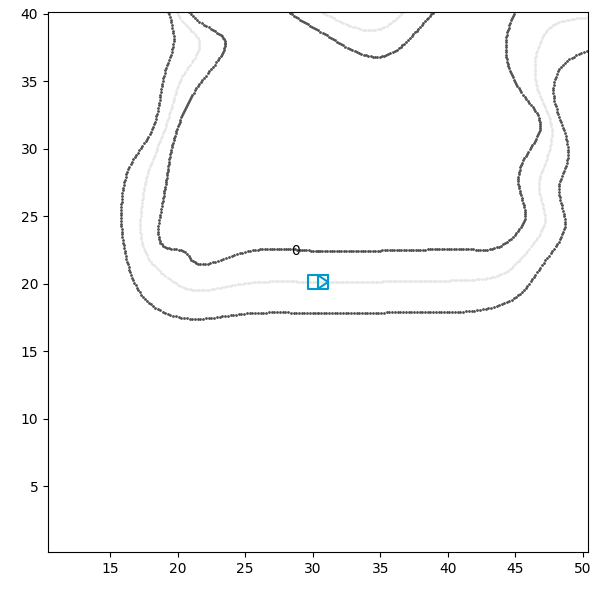

In [36]:
state = create_init_state()
# print(state.sim_trajectory.valid)
# print(state.sim_trajectory.xy[0,:10])
img=visualization.plot_simulator_state(state, use_log_traj=False, viz_config=viz_cfg)
mediapy.show_image(img)

In [37]:
# for multiagent env
# dummy_action = actor_core.WaymaxActorOutput(actor_state=None, 
#                                      action = datatypes.Action(data=jnp.array([[0.0, 0.2, 0.2]]), valid=jnp.array([[True]])), 
#                                      is_controlled=jnp.array([True]))

# for planning agent env
dummy_action = actor_core.WaymaxActorOutput(actor_state=None, 
                                     action = datatypes.Action(data=jnp.array([0.0, 0.2, 0.2]), valid=jnp.array([True])), 
                                     is_controlled=jnp.array([True]))

In [38]:
# dynamics_model = dynamics.StateDynamics()
dynamics_model = TricycleModel(gk_geometry=GoKartGeometry(), model_params=TricycleParams(), paj_params=PajieckaParams())

# Expect users to control all valid object in the scene.
# env = _env.MultiAgentEnvironment(
#     dynamics_model=dynamics_model,
#     config=dataclasses.replace(
#         _config.EnvironmentConfig(),
#         max_num_objects=1,
#         init_steps = 1
#     ),
# )

env = _env.PlanningAgentEnvironment(
    dynamics_model=dynamics_model,
    config=dataclasses.replace(
        _config.EnvironmentConfig(),
        max_num_objects=1,
        init_steps = 1  # state.timestep = 0
    ),
)

In [39]:
# dynamics_model = dynamics.StateDynamics()
# actor = agents.create_constant_speed_actor(
#     speed=2.0,
#     dynamics_model=dynamics_model,
#     is_controlled_func=lambda state: jnp.array([True]),
# )

In [40]:
jit_step = jax.jit(env.step)
# jit_select_action = jax.jit(actor.select_action)

In [41]:
states = [env.reset(state)]
for _ in range(states[0].remaining_timesteps):
  current_state = states[-1]

  # action = jit_select_action({}, current_state, None, None)
  
  next_state = jit_step(current_state, action = dummy_action.action)

  states.append(next_state)

In [44]:
# print(state.sim_trajectory.xy[0,:3])
# print(state.log_trajectory.xy[0,:3])
# print(state.sim_trajectory.valid[0,:3])
# print(state.log_trajectory.valid[0,:3])
print(states[0].sim_trajectory.xy[0,:3])
print(states[0].timestep)
print(states[0].current_sim_trajectory.xy[0])
print(states[0].log_trajectory.xy[0,:3])
print(states[0].sim_trajectory.valid[0,:3])
print(states[0].log_trajectory.valid[0,:3])
print(states[0].remaining_timesteps)
print(states[1].sim_trajectory.xy[0,:3])
print(states[1].log_trajectory.xy[0,:3])
print(states[1].sim_trajectory.valid[0,:3])
print(states[1].log_trajectory.valid[0,:3])
print(states[1].remaining_timesteps)

[[30.3914 20.1282]
 [-1.     -1.    ]
 [-1.     -1.    ]]
0
[[30.3914 20.1282]]
[[30.3914 20.1282]
 [ 0.      0.    ]
 [ 0.      0.    ]]
[ True False False]
[ True False False]
99
[[30.3914 20.1282]
 [30.3934 20.1282]
 [-1.     -1.    ]]
[[30.3914 20.1282]
 [ 0.      0.    ]
 [ 0.      0.    ]]
[ True  True False]
[ True False False]
98


In [43]:
imgs = []
for state in states:
  imgs.append(visualization.plot_simulator_state(state, use_log_traj=False,viz_config=viz_cfg))
# imgs = [visualization.plot_simulator_state(states[0], use_log_traj=False)]
# print(states[0].object_metadata)
mediapy.show_video(imgs, fps=10)